In [ ]:
from pafpy import PafFile, Strand
from tqdm.notebook import tqdm
from collections import defaultdict, Counter
import intervaltree as itree
from Bio import SeqIO
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from collections import defaultdict
import time
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams.update({'font.size': 18})



In [ ]:
human_ref = "/home/Users/blk6/Data/assemblies/human-ref/T2T_v2.1.fna"
human_index = SeqIO.index(human_ref, "fasta")

In [ ]:
ONT92_file = "/home/Users/blk6/Data/reads/human/ONT-92.fa"
ONT92_index = SeqIO.index(ONT92_file, "fasta")

In [ ]:
HG002_file = "/home/Users/blk6/Data/reads/human/HG002-HiFi.fa"
HG002_index = SeqIO.index(HG002_file, "fasta")

In [1373]:
ONT96_file = "/home/Users/blk6/Data/reads/human/ONT-96-5000-d2.fa"
ONT96_index = {record.id : record for record in tqdm(SeqIO.parse(ONT96_file, "fasta"))}

0it [00:00, ?it/s]

In [ ]:
HiFi_file = "/home/Users/blk6/Data/reads/human/HiFi-5000-d2.fa"
HiFi_index = SeqIO.index(HiFi_file, "fasta")

In [1231]:
fnames_mashmap_new = """qname
qlen
qstart
qend
strand
tname
tlen
tstart
tend
nmatch
alen
mapq""".split("\n")

fnames_mashmap_orig = """qname
qlen
qstart
qend
strand
tname
tlen
tstart
tend
ANI""".split("\n")

In [ ]:
from multiprocessing import Process, Manager
from functools import partial
    
def parse_maf_for_ANI(rid_to_ANI_shared, dataset):
    counter = 0
    private_d = {}
    for line_no, line in enumerate(line.strip() for line in open(f"/home/Users/blk6/Data/reads/human/{dataset}-5000-d2.maf")):
        if line == "":
            continue
        if line[0] == "a":
            if counter == 2:
                match_columns = sum(ref_aln[i] == query_aln[i] for i in range(len(query_aln)))
                total_columns = len(ref_aln)
                # print(match_columns / total_columns)
                private_d[rid] = match_columns / total_columns
            counter = 0
        elif line[0] == "s" and counter == 0:
            counter += 1
            ref_aln = line.split(" ")[-1].upper()
        elif line[0] == "s" and counter == 1:
            rid = line.split(" ")[1]
            query_aln = line.split(" ")[-1].upper()
            counter += 1
        if line_no % 100000== 0:
            print(dataset, line_no)
    rid_to_ANI_shared[dataset].update(private_d)
    
def get_ANI_dict():  
    with Manager() as manager:
        rid_to_ANI = manager.dict({dataset: manager.dict() for dataset in ["HiFi", "ONT-96", "ONT-92" ]})
        with manager.Pool(4) as pool:
            partial_f = partial(parse_maf_for_ANI, rid_to_ANI)
            pool.map(partial_f, ["HiFi", "ONT-96", "ONT-92" ])

        return {dataset: dict(d) for (dataset, d) in dict(rid_to_ANI).items()}
        
rid_to_ANI = get_ANI_dict()

In [1781]:
k=31
ss=75
dataset = "ONT-96"
rid_to_ANI_dataset = rid_to_ANI["ONT-96"]
read_index = ONT96_index
from csv import DictReader
out_paf = f"/home/Users/blk6/Contribute/MashMap/{dataset}-ss{ss}-k{k}-n1.paf"
orig_out_paf = f"/home/Users/blk6/Contribute/MashMap/{dataset}-ss{ss}-k{k}-n1-orig.paf"
wfmash_out_paf = f"/home/Users/blk6/Contribute/MashMap/{dataset}-ss{ss}-k{k}-n1-wfmash.paf"
minimap_paf_file = f"/home/Users/blk6/Contribute/wfmash/{dataset}-minimap2.paf"

In [1802]:
new_paf_file = out_paf
orig_paf_file = orig_out_paf
wfmash_paf_file = wfmash_out_paf
minimap_paf_file = minimap_paf_file

method_to_rids = defaultdict(set)

rid_to_lines = defaultdict(lambda: defaultdict(list))
with open(new_paf_file, 'r') as paf_f:
    paf_reader = (DictReader(paf_f, delimiter='\t', fieldnames = fnames))
    for record in tqdm(paf_reader):
        try:
            for fn in ["qstart", "qend", "tstart", "tend", "nmatch"]:
                record[fn] = int(record[fn])
            rid = record["qname"]
            record["predicted_ANI"] = float(record[None][0].split(":")[-1])/100
            rid_to_lines[rid]["new"].append(record)
            method_to_rids[method].add(rid)
        except Exception as e:
            print(e)
        
with open(wfmash_paf_file, 'r') as paf_f:
    paf_reader = (DictReader(paf_f, delimiter='\t', fieldnames = fnames))
    for record in tqdm(paf_reader):
        try:
            for fn in ["qstart", "qend", "tstart", "tend", "nmatch"]:
                record[fn] = int(record[fn])
            rid = record["qname"]
            record["predicted_ANI"] = float(record[None][0].split(":")[-1])/100
            rid_to_lines[rid]["wfmash"].append(record)
            method_to_rids[method].add(rid)
        except Exception as e:
            print(e)
        
with open(orig_paf_file, 'r') as paf_f:
    paf_reader = (DictReader(paf_f, delimiter=' ', fieldnames = fnames_orig))
    for record in tqdm(paf_reader):
        try:
            for fn in ["qstart", "qend", "tstart", "tend"]:
                record[fn] = int(record[fn])
            record["ANI"] = float(record["ANI"]) / 100
            rid = record["qname"]
            rid_to_lines[rid]["orig"].append(record)
            rid_to_lines[rid]["orig"][-1]["predicted_ANI"] = record["ANI"]
            method_to_rids[method].add(rid)
        except Exception as e:
            break
            print(e)
   
with open(minimap_paf_file, 'r') as paf_f:
    paf_reader = (DictReader(paf_f, delimiter='\t', fieldnames = fnames))
    for record in tqdm(paf_reader):
        try:
            for fn in ["qstart", "qend", "tstart", "tend", "nmatch"]:
                record[fn] = int(record[fn])
            rid = record["qname"]
            rid_to_lines[rid]["minimap"].append(record)
        
            for item in record[None]:
                tag, vartype, val = item.split(":")
                if tag == "dv":
                    rid_to_lines[rid]["minimap2"][-1]["predicted_ANI"] = 1 - float(val)
            method_to_rids[method].add(rid)
        except Exception as e:
            break
            print(e)
         
        
RIDS =  new_rids & orig_rids & minimap_rids
    

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [1484]:
def flatten(l):
    return [item for sublist in l for item in sublist]

In [ ]:
key = "predicted_ANI"

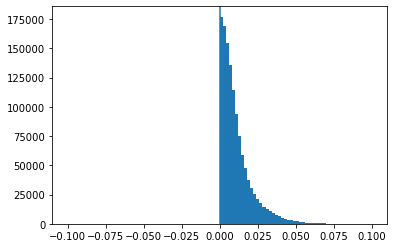

In [1776]:
import scipy
methods =  ["mashmap2", "mashmap3", "minimap2"]
method_diffs = defaultdict(list)
for method in methods:
    for rid in read_index.keys():
        best_pred = -1
        for record in rid_to_lines[rid]["orig"]:
            try:
                best_pred = max(best_pred, record[key])
            except Exception as e:
                print(e)
                break
        try:
            if best_pred >= 0:
                method_diffs[method].append(abs(best_pred - rid_to_ANI_dataset[rid.split("!")[0]]))
        except:
            pass
    plt.title(method)
    plt.hist(method_diffs[method], bins = np.linspace(-.1, .1, 101))
    plt.axvline(0)
    plt.show()
    
for method in methods:
    diff = method_diffs[method]
    desc = stats.describe(diff)
    print(f"{method}:\tN={desc.nobs}\tMean={desc.mean : .5f}\tVar={desc.variance: .5f}")


In [1780]:
import scipy
from pprint import pprint
for diff in [orig_diffs, wfmash_diffs, new_diffs, minimap_diffs]:
    desc = stats.describe(diff)
    print(f"N={desc.nobs}\tMean={desc.mean : .5f}\tVar={desc.variance: .5f}")


N=1245140	Mean= 0.01078	Var= 0.00011
N=1242794	Mean= 0.01158	Var= 0.00011
N=1245124	Mean= 0.01157	Var= 0.00011
N=1246150	Mean= 0.01177	Var= 0.00039


In [1724]:
methods = ["MashMap2", "MashMap3", "Minimap2" ]
computational = {
    "ONT-92" : {
        "num-reads": 1000000,
        "Minimap2": {"Empty-fasta": 161, "reads": 6345, "Memory": 10.2, 
                     "Jaccard Error": {"mean": -.0006, "var": .00044},
                     "ANI Error": {"mean": 0.01177, "var": 0.04569}},
        "MashMap2": {"Empty-fasta": 220, "reads": 219121, "Memory": 10.7,
                     "Jaccard Error": {"mean": 0.01158, "var": 0.00092},
                     "ANI Error": {"mean": 0.01078, "var": 0.04569}},
        "minmer-MashMap2": {"Empty-fasta": 3112, "reads": 4702, "Memory": 13.5,
                     "Jaccard Error": {"mean": 0.0003, "var": .00067},
                     "ANI Error": {"mean": 0.01158, "var": 0.04569}}
    },
    
    "ONT-96" : {
        "num-reads": 1000000,
        "Minimap2": {"Empty-fasta": 160, "reads": 9401, "Memory": 10.3, 
                     "Jaccard Error": {"mean": -.0262, "var": .0038},
                     "ANI Error": {"mean": 0.01561, "var": 0.04569}},
        "MashMap2": {"Empty-fasta": 201, "reads": 111629, "Memory": 8.5,
                     "Jaccard Error": {"mean": 0.034, "var": 0.00392},
                     "ANI Error": {"mean": 0.00591, "var": 0.04569}},
        "minmer-MashMap2": {"Empty-fasta": 3010, "reads": 4221, "Memory": 10.7,
                     "Jaccard Error": {"mean": -0.003, "var": .00267},
                     "ANI Error": {"mean": 0.00651, "var": 0.04569}}
    },
    
    "HiFi-999" : {
        "num-reads": 1000000,
        "Minimap2": {"Empty-fasta": 103, "reads": 2041, "Memory": 11.5, 
                     "Jaccard Error": {"mean": 0.00139, "var": 0.04569},
                     "ANI Error": {"mean": 0.00243, "var": 0.04569}},
        "MashMap2": {"Empty-fasta": 240, "reads": 3499, "Memory": 7.1, 
                     "Jaccard Error": {"mean": 0.10098, "var": 0.01406},
                     "ANI Error": {"mean": 0.00041, "var": 0.04569}},
        "minmer-MashMap2": {"Empty-fasta": 3001, "reads": 4340, "Memory": 8.1, 
                     "Jaccard Error": {"mean": -0.01370, "var": 0.00605},
                     "ANI Error": {"mean": 0.00038, "var": 0.04569}}
    }
}

for dataset, results in computational.items():
    for method in methods:
        results[method]["Maptime"] = results[method]["reads"] - results[method]["Empty-fasta"]

In [ ]:
N=1246927	Mean= 0.00041	Var= 0.00000
N=1246927	Mean= 0.00038	Var= 0.00000
N=1246927	Mean= 0.00038	Var= 0.00000
N=1246927	Mean= 0.00139	Var= 0.00000

In [1717]:
for method in methods:
    line = method
    for dataset in ["ONT-92", "ONT-96", "HiFi-999"]:
        results = computational[dataset]
        method_results = results[method]
        line += f" & {method_results['Empty-fasta']/ 60 : .2f}"
        line += f" & {method_results['Maptime']/ 60 : .2f}"
        line += f" & {method_results['Memory'] }"
        if "ANI Error" in method_results:
            line += f" & {method_results['ANI Error']['mean'] * 100: 0.2f}"
        else:
            line += " & "
    print(line + "\\\\")
    print("\\hline")

minmer-MashMap2 &  51.87 &  26.50 & 13.5 &  1.17 &  50.17 &  20.18 & 10.7 &  0.65 &  50.02 &  22.32 & 8.1 &  0.04\\
\hline
minimizer-MashMap2 &  3.67 &  3648.35 & 10.7 &  1.08 &  3.35 &  1857.13 & 8.5 &  0.59 &  4.00 &  54.32 & 7.1 &  0.04\\
\hline
Minimap2 &  2.68 &  103.07 & 19.7 &  2.20 &  2.67 &  154.02 & 20.3 &  1.56 &  1.72 &  32.30 & 11.5 &  0.24\\
\hline


In [1294]:
from multiprocessing import Process, Manager
from functools import partial
    
def parse_maf_for_ANI(rid_to_ANI_shared, dataset):
    counter = 0
    private_d = {}
    for line_no, line in enumerate(line.strip() for line in open(f"/home/Users/blk6/Data/reads/human/{dataset}-5000-d2.maf")):
        if line == "":
            continue
        if line[0] == "a":
            if counter == 2:
                match_columns = sum(ref_aln[i] == query_aln[i] for i in range(len(query_aln)))
                total_columns = len(ref_aln)
                # print(match_columns / total_columns)
                private_d[rid] = match_columns / total_columns
            counter = 0
        elif line[0] == "s" and counter == 0:
            counter += 1
            ref_aln = line.split(" ")[-1].upper()
        elif line[0] == "s" and counter == 1:
            rid = line.split(" ")[1]
            query_aln = line.split(" ")[-1].upper()
            counter += 1
        if line_no % 100000== 0:
            print(dataset, line_no)
    rid_to_ANI_shared[dataset].update(private_d)
    
def get_ANI_dict():  
    with Manager() as manager:
        rid_to_ANI = manager.dict({dataset: manager.dict() for dataset in ["HiFi", "ONT-96", "ONT-92" ]})
        with manager.Pool(4) as pool:
            partial_f = partial(parse_maf_for_ANI, rid_to_ANI)
            pool.map(partial_f, ["HiFi", "ONT-96", "ONT-92" ])

        return {dataset: dict(d) for (dataset, d) in dict(rid_to_ANI).items()}
        
rid_to_ANI = get_ANI_dict()